In [1]:
%matplotlib inline
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn import datasets

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.optimizers import SGD
from keras import regularizers

from keras.datasets import cifar10

from kerasutils import hits_and_misses, describe_model
from imageutils import block_dct
from imageutils import dataset_transform_block_dct

import matplotlib.pyplot as plt
import numpy as np

import random

/home/jmoore/.virtualenvs/dl4cv/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
(trainX_orig, trainY_orig), (testX, testY) = cifar10.load_data()

In [3]:
# Have to decimate training set size due to memory constraints?
(trainX, testX_dummy, trainY, testY_dummy) = train_test_split(trainX_orig, trainY_orig, test_size=0.25)

In [4]:
trainX = trainX / 255.0
testX = testX / 255.0
print(trainX.shape)
print(testX.shape)
print(trainX.dtype)

(37500, 32, 32, 3)
(10000, 32, 32, 3)
float64


In [5]:
trainX = dataset_transform_block_dct(trainX)
testX = dataset_transform_block_dct(testX)
print(trainX.shape)
print(testX.shape)

(37500, 56, 56, 3)
(10000, 56, 56, 3)


In [8]:
# Transform labels from int to one-hot vectors
lb = LabelBinarizer()
trainY = lb.fit_transform(trainY)
testY = lb.fit_transform(testY)

print(trainY.shape)
print(testY.shape)
n_classes = trainY.shape[1]
height = trainX.shape[1]
width = trainX.shape[2]
channels = trainX.shape[3]

(37500, 10)
(10000, 10)


In [49]:
# "Transform" CNN architecture with Keras
model = Sequential()
model.add(Conv2D(input_shape=(height,width,channels), filters=64,  
                 use_bias=True, kernel_size=(8,8), strides=8))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(Conv2D(filters=64,use_bias=True, kernel_size=(3,3)))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(lb.classes_.shape[0], activation="softmax"))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [58]:
n_epochs = 50
batch_size = 256
H = model.fit(trainX, trainY, validation_data=(testX, testY), 
              epochs=n_epochs, batch_size=batch_size)
print('Done!!!')

Train on 37500 samples, validate on 10000 samples
Epoch 1/50
37500/37500 [==============================] - 8s 211us/step - loss: 0.4720 - acc: 0.8301 - val_loss: 0.8756 - val_acc: 0.7177
Epoch 2/50
37500/37500 [==============================] - 8s 209us/step - loss: 0.4612 - acc: 0.8349 - val_loss: 0.8797 - val_acc: 0.7188
Epoch 3/50
37500/37500 [==============================] - 8s 207us/step - loss: 0.4562 - acc: 0.8341 - val_loss: 0.8700 - val_acc: 0.7205
Epoch 4/50
37500/37500 [==============================] - 8s 206us/step - loss: 0.4524 - acc: 0.8378 - val_loss: 0.8981 - val_acc: 0.7191
Epoch 5/50
37500/37500 [==============================] - 8s 212us/step - loss: 0.4366 - acc: 0.8419 - val_loss: 0.8886 - val_acc: 0.7188
Epoch 6/50
37500/37500 [==============================] - 8s 219us/step - loss: 0.4272 - acc: 0.8444 - val_loss: 0.9139 - val_acc: 0.7220
Epoch 7/50
37500/37500 [==============================] - 8s 221us/step - loss: 0.4304 - acc: 0.8444 - val_loss: 0.8936 - 

In [59]:
# Evaluate TEST model class prediction accuracy
print("[INFO] Evaluating network...")
predictions = model.predict(testX, batch_size=batch_size)
target_names = [str(x) for x in lb.classes_]
print(classification_report(testY.argmax(axis=1),
                            predictions.argmax(axis=1),
                            target_names=target_names))


[INFO] Evaluating network...
             precision    recall  f1-score   support

          0       0.74      0.79      0.76      1000
          1       0.84      0.83      0.83      1000
          2       0.60      0.67      0.63      1000
          3       0.55      0.48      0.51      1000
          4       0.67      0.70      0.68      1000
          5       0.62      0.59      0.61      1000
          6       0.77      0.81      0.79      1000
          7       0.79      0.73      0.76      1000
          8       0.84      0.84      0.84      1000
          9       0.82      0.78      0.80      1000

avg / total       0.72      0.72      0.72     10000



In [60]:
# Evaluate TRAIN model class prediction accuracy
print("[INFO] Evaluating network...")
trainPreds = model.predict(trainX, batch_size=batch_size)
target_names = [str(x) for x in lb.classes_]
print(classification_report(trainY.argmax(axis=1),
                            trainPreds.argmax(axis=1),
                            target_names=target_names))

[INFO] Evaluating network...
             precision    recall  f1-score   support

          0       1.00      1.00      1.00      3753
          1       1.00      1.00      1.00      3791
          2       0.99      1.00      0.99      3774
          3       1.00      0.99      0.99      3696
          4       0.99      1.00      0.99      3725
          5       1.00      0.99      1.00      3762
          6       1.00      1.00      1.00      3724
          7       1.00      1.00      1.00      3724
          8       1.00      1.00      1.00      3731
          9       1.00      1.00      1.00      3820

avg / total       1.00      1.00      1.00     37500



In [37]:
describe_model(model)

Layer 0: <class 'keras.layers.convolutional.Conv2D'>
    input=(None, 56, 56, 3)
    output=(None, 7, 7, 32)
    act=<function linear at 0x7fe20bc871e0>
    strides=(8, 8)
Layer 1: <class 'keras.layers.core.Activation'>
    input=(None, 7, 7, 32)
    output=(None, 7, 7, 32)
    act=<function relu at 0x7fe20bc78f28>
Layer 2: <class 'keras.layers.core.Dropout'>
    input=(None, 7, 7, 32)
    output=(None, 7, 7, 32)
    rate=0.1
Layer 3: <class 'keras.layers.convolutional.Conv2D'>
    input=(None, 7, 7, 32)
    output=(None, 5, 5, 64)
    act=<function linear at 0x7fe20bc871e0>
    strides=(1, 1)
Layer 4: <class 'keras.layers.core.Activation'>
    input=(None, 5, 5, 64)
    output=(None, 5, 5, 64)
    act=<function relu at 0x7fe20bc78f28>
Layer 5: <class 'keras.layers.core.Dropout'>
    input=(None, 5, 5, 64)
    output=(None, 5, 5, 64)
    rate=0.2
Layer 6: <class 'keras.layers.core.Flatten'>
    input=(None, 5, 5, 64)
    output=(None, 1600)
Layer 7: <class 'keras.layers.core.Dense'>
  

In [47]:
layer = model.layers[2]
layer.rate = 0.1

print(layer.rate)
print(layer.get_config())

0.1
{'seed': None, 'noise_shape': None, 'rate': 0.1, 'trainable': True, 'name': 'dropout_1'}


In [11]:
preds = predictions.argmax(axis=1)
targets = testY.argmax(axis=1)
hits, misses = hits_and_misses(preds, targets)
print('{0} hits, {1} misses ({2}%)'.format(len(hits), len(misses), len(hits)/float(len(predictions))))

6775 hits, 3225 misses (0.6775%)


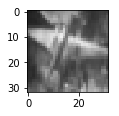

Target: 0, Predicted: 3


In [16]:
# Look at examples of misses
from imageutils import bgr2rgb
idx = misses[random.randint(0,len(misses))]
im = testX[idx]
plt.figure(figsize=(1.5,1.5))
plt.imshow(bgr2rgb(im))
plt.show()
print('Target: {0}, Predicted: {1}'.format(targets[idx], preds[idx]))


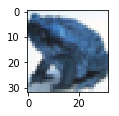

Target: 6, Predicted: 6


In [17]:
# Look at examples of hits
from imageutils import bgr2rgb
idx = hits[random.randint(0,len(hits))]
im = testX[idx]
plt.figure(figsize=(1.5,1.5))
plt.imshow(bgr2rgb(im))
plt.show()
print('Target: {0}, Predicted: {1}'.format(targets[idx], preds[idx]))